In [ ]:
%matplotlib inline

# Sensory evoked potentials

We will spend this lab session testing out a couple of evoked potentials for ourselves! As we go through this lab session, I encourage you to keep in mind a couple of questions:
* What do we know about how the signal typically looks like?
* What about our current Muse setup would make this signal potentially look different?

Embedded in this notebook are questions that you will be asked to answer as part of your lab report. The assignment on Canvas should also provide a copy of these questions.

In [1]:
# Imports: these are the packages we'll need to run today's trials.
import os
from eegnb import generate_save_fn
from eegnb.devices.eeg import EEG
from eegnb.experiments.visual_ssvep import ssvep
from eegnb.experiments.auditory_ssaep import ssaep
from eegnb.experiments.visual_vep import vep

# Some standard pythonic imports
import os, numpy as np, pandas as pd
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.time_frequency import Spectrum, tfr_morlet

# EEG-Notebooks functions
from eegnb.analysis.utils2 import load_data,plot_conditions, check_report
from eegnb.datasets import fetch_dataset

pygame 2.1.2 (SDL 2.0.18, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Steady-state visual evoked potential (SSVEP)

The SSVEP is a signal generated by repeatedly presenting a visual stimulus at a particular rate, so called because it involves the steady presentation of a stimulus and the response being one automatically generated (i.e. evoked) by a visual stimulus. 

### Experiment set-up

In [ ]:
# Define some variables
board_name = "muse2_bfn" # you'll keep this the same, this is the method we are telling the computer we want to record EEG
experiment = "visual_ssvep" # this is going to change depending on the experiment that you are running (you'll see it changes below)
subject_id = 0 # change when you are recording a different person
session_nb = 0 # change when you are recording the same person but with a different condition
record_duration = 120

After this set-up, we will want to make sure we're using the right inputs before starting the experiment. Here's one way of looking at the inputs, based on where our data will be saved:

In [ ]:
eeg_device = EEG(device=board_name, serial_num='Muse-B00E') # change 'Muse-4DID' to whatever the 4-digit ID on your Muse is!

# Create save file name
save_fn = generate_save_fn(board_name, experiment, subject_id, session_nb)
print(save_fn)

If the subject and session are labeled with the right places, then that's where you'll find the data when the file is saved after the experiment runs. This is good to keep in mind for when you go find the data for analysis after.

Also, make sure you run the above cell once before every time you want to record the experiment. You'll see that the recording file name is time-stamped - if you don't run the cell again, you'll save over your old file with a new recording!

### Run experiment

Before starting an experiment, you want to make sure your data aren't too noisy. One way of doing this is to run a signal quality check:

In [ ]:
check_report(eeg_device)

If you want to continue signal quality checks after the first 5, just hit ENTER. It'll continue to the next 5. To stop, press c before ENTER.

To start the experiment, just run the block of code below after running the previous blocks. 

In [ ]:
ssvep.present(duration=record_duration, eeg=eeg_device, save_fn=save_fn)

If you are running the experiment multiple times, whether that's multiple sessions for a person or with different people, make sure that you are first running the previous cells where you change subject/session and also where the file is saved - otherwise, the files you generate will end up in the wrong folders, or you'll save over your own file!

### Predictions

Before we move on, please answer the following questions: 

* We are going to be looking at data based on frequency spectrum. What do you think we'll be able to see when looking at frequency data for the experiment that you just did? 

### Visualize data

We're going to look at the data to see how they come out in response to the stimuli we've presented. The first step is to load out the data that we've just recorded.

In [2]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    

# to load data from a specific subject and session:
subject = 0
session = 0
# make sure that these numbers are correct, or it will run from the last time you used 'subject' and 'session', 
# including from above!

raw = load_data(subject,session,
                experiment='visual_ssvep', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path)

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=30700
    Range : 0 ... 30699 =      0.000 ...   119.918 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=90028
    Range : 0 ... 90027 =      0.000 ...   351.668 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=31312
    Range : 0 ... 31311 =      0.000 ...   122.309 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=42472
    Range : 0 ... 42471 =      0.000 ...   165.902 secs
Ready.


The number of files you've read out (each file readout will tell you its length in seconds and then say 'Ready.' after) should correspond to the number of recordings you've done in that session. If it doesn't, go back and check.

We're going to do a couple of things here that we won't go into now, but will help the final visual look like what it does above. We'll talk more about this process when we spend time formally going through the analysis pipeline.

In [ ]:
# Next, we will chunk (epoch) the data into segments representing the data 500ms before to 4s after each stimulus.

events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}
epochs = Epochs(raw, events=events, event_id=event_id,
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=[0, 1, 2, 3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

We're looking for that sample drop % to be as low as possible. If yours is higher than 15%, check the raw number of trials that have come out. It could be that the original recording was a bit noisy, and that's okay.

Make sure you have at least 30 trials (where it says '(number) events found' tells you the trial count) before trying to run the next cell. 

In [ ]:
# Next, we can compare the PSD of epochs specifically during 20hz and 30hz stimulus presentation

f, ax = plt.subplots()
psd1, freq1 = epochs['30 Hz'].compute_psd(method='welch', n_fft=1028, n_per_seg=256 * 3, picks='all').get_data(return_freqs=True)
psd2, freq2 = epochs['20 Hz'].compute_psd(method='welch', n_fft=1028, n_per_seg=256 * 3, picks='all').get_data(return_freqs=True)
#psd1, freq1 = psd_welch(epochs['30 Hz'], n_fft=1028, n_per_seg=256 * 3, picks='all')
#psd2, freq2 = psd_welch(epochs['20 Hz'], n_fft=1028, n_per_seg=256 * 3, picks='all')
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)

psd2_mean = psd2.mean(0)

ax.plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='30 Hz')
ax.plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='20 Hz')

ax.set_title('TP9 and TP10')

ax.set_ylabel('Power Spectral Density (dB)')

ax.set_xlim((2, 50))

ax.set_xlabel('Frequency (Hz)')

ax.legend()

plt.show();

# With this visualization we can clearly see distinct peaks at 30hz and 20hz in the PSD, corresponding to the frequency of the visual stimulation. 

Your output should have some semblance of the figure below (semblance is loose, don't worry):

![SSVEP](ssvep.png)

Answer the following questions: 

* What similarities or diferences do you notice between your graph and the sample one? Why do you think they are present? 

Use the below cell to save your figure (it will save in the introeeg_labs folder that you are currently in, just make sure to upload or email to yourself to have a copy for future reference).

In [ ]:
# use this command to save your files (replace [yourname] with your name so you know which file is yours):
plt.savefig('[yourname]_ssvep.png')

In [ ]:
# We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time

frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs['30 Hz'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=[0], baseline=(-0.5, -0.1), mode='logratio',
                 title='30 Hz stim');

tfr, itc = tfr_morlet(epochs['20 Hz'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=[0], baseline=(-0.5, -0.1), mode='logratio',
                 title='20 Hz stim');

plt.tight_layout()

# SSVEPs clearer with 20Hz than 30Hz

Filtering raw data in 4 contiguous segments
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

136 events found
Event IDs: [1 2]


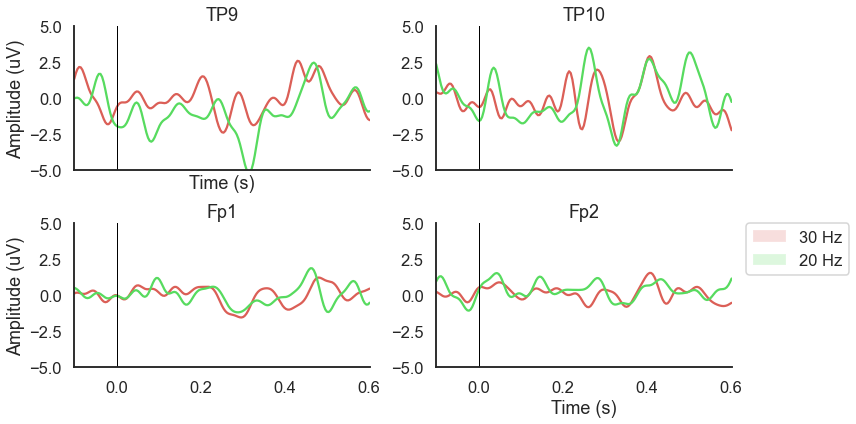

In [5]:
## sandboxing: can I see the VEP with the SSVEP stimuli?

raw_filt = raw.copy().filter(1, 20, method='iir')
events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}
epochs = Epochs(raw_filt, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.6, baseline=(-0.1,0),
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3])
conditions = OrderedDict()
conditions['30 Hz'] = [1]
conditions['20 Hz'] = [2]

fig, ax = plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1, title='',
                                diff_waveform=None, 
                                channel_order=[0,1,3,2], ylim=(-5, 5))

Answer the following questions:

* Run the visualization again once you've collected 100 trials, and then 200 trials. What is different between the first time you visualized the file and these new visualizations? What might you expect to be different and why?
* Where do you think this signal is originating from? Is the signal stronger or weaker than you might expect, given what we're recording with? Why?

## Visual Evoked Potential (VEP)

The visual evoked potential is seen when visual stimuli are presented to an observer. 

NOTE: You'll see that some of the cells are the same as the ones above, or very similar. They're technically the same code, but I'm just repeating it down here so you don't overwrite what's above. Also, this way you can just skip down to this section if you're only interested in running the VEP!

### Experiment set-up

In [ ]:
# Define some variables
board_name = "muse2_bfn" # you'll keep this the same, this is the method we are telling the computer we want to record EEG
experiment = "visual_vep" # this is going to change depending on the experiment that you are running (you'll see it changes below)
subject_id = 1 # change when you are recording a different person
session_nb = 1 # change when you are recording the same person but with a different condition
record_duration = 120

In [ ]:
# set up the connection to the EEG device and what the file name will be
eeg_device = EEG(device=board_name, serial_num='Muse-B00E')

# Create save file name
save_fn = generate_save_fn(board_name, experiment, subject_id, session_nb)
print(save_fn)

In [ ]:
# checking signal quality before continuing
check_report(eeg_device)

In [ ]:
vep.present(duration=record_duration, eeg=eeg_device, save_fn=save_fn)

Before you continue, you'll want to run this task a couple of times. I'd suggest 3 recordings of 120 seconds.

### Visualize data

This time, we will be visualizing the data as ERPs.

In [ ]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    

# to load data from a specific subject and session:
subject = 1
session = 1
# make sure that these numbers are correct, or it will run from the last time you used 'subject' and 'session', 
# including from above!

raw = load_data(subject,session,
                experiment='visual_vep', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path)

In [ ]:
raw.filter(1,20, method='iir')
# raw.plot_psd(fmin=1, fmax=30); # visualize power spectrum after filtering

# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'Left': 1, 'Right': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.6, baseline=(-0.1, 0),
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

In [ ]:
conditions = OrderedDict()
conditions['Left'] = [1]
conditions['Right'] = [2]

fig, ax = plot_conditions(epochs, conditions=conditions, 
                          n_boot=1000, title='', ci=0,
                          channel_order=[0,1,3,2],
                          diff_waveform=None)

Your graph will hopefully look something like this:

![VEP](vep_sample.png)

Answer the following questions:

* Describe the pattern of activity you observed. Do you see any canonical ERPs?
* Do you see a separation in pattern related to the presentation of left and right stimuli? Why do you think this is?
* Try comparing what happens when someone is paying attention to the stimuli versus not paying attention. How do you plan on keeping track of attention? Did it affect the ERPs you identified earlier?

## Steady-state auditory evoked potential (SSAEP)

The SSAEP (also known as the auditory steady state response, or ASSR) is generated when 